In [2]:
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
from scipy.spatial.distance import cdist
import sys
sys.path += ["../src"]
import config
import utils
from glob import glob
import gzip
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import subplots as sbp
import json
from jl_synthetic_pop_all_vae_provinces_airbnb import read_gz, read_json, get_df_city_for_nf
from jl_synthetic_pop_all_vae_provinces_airbnb import read_json


In [3]:
import pickle
from airbnb_all_baselines import from_cat_to_dummies_airbnb, select_n_in_border

In [4]:
airbnb_path = "/data/housing/data/intermediate/jl_pop_synth/airbnb/"


In [5]:
cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'Air conditioning',
       'Elevator', 'Self check-in', 'Pets allowed', 'Private living room',
       'Backyard', 'Pool', 'roomtype_Entire home/apt',
       'roomtype_Hotel room', 'roomtype_Private room', 'roomtype_Shared room',
       'review_scores_rating', 'reviews_per_month',
       'log_price', 'x', 'y']

amenities_vars = ["Air conditioning", "Elevator", "Self check-in", "Pets allowed", "Private living room", "Backyard", "Pool"]

In [16]:
date = "250924"

for city in ["brisbane", "hawaii", "naples", "paris", "barcelona", "copenhagen", "washington dc", #"rhode island","oslo","oakland",
             "montreal","cape town" ,"lyon","mexico city","santiago","hong-kong","seattle", "austin","singapore"]:
    print(city)
    gdf_full = read_json(city)

    df_nfvae = pd.read_csv(airbnb_path + f"pop_samples/synthetic_pop_{city}_{date}.csv", index_col = 0)
    df_nfvae95 = pd.read_csv(airbnb_path + f"pop_samples/synthetic_pop_{city}_{date}_95.csv", index_col = 0)
    df_vae = pd.read_csv(airbnb_path + f"pop_samples/synthetic_pop_{city}_{date}_ablation.csv", index_col = 0)
    df_vae95 = pd.read_csv(airbnb_path + f"pop_samples/synthetic_pop_{city}_{date}_ablation_95_ablation.csv", index_col = 0)
    df_real = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_real_{date}.csv", index_col = 0)
    df_real95 = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_real95_{date}.csv", index_col = 0)
    #df_ipf = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_ipf_{date}.csv", index_col = 0)
    #df_ipf95 = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_ipf95_{date}.csv", index_col = 0)
    dfs_shuffle = {}
    dfs_shuffle95 = {}
    for with_bins in [0,1]:
        for province_shuffle in [0,1]:
            dfs_shuffle[(with_bins, province_shuffle)] = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_shuffle_with_bins{with_bins}_shuffle_province{province_shuffle}.csv", index_col = 0)
            dfs_shuffle95[(with_bins, province_shuffle)] = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_shuffle95_with_bins{with_bins}_shuffle_province{province_shuffle}.csv", index_col = 0)
    
    df_copula = pd.read_csv(airbnb_path +f"pop_samples/{city}_df_copula_{date}.csv", index_col = 0)
    df_nf_copula = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_nf_copula_{date}.csv", index_col = 0)
    df_copula95 = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_copula95_{date}.csv", index_col = 0)
    df_nf_copula95 = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_nf_copula95_{date}.csv", index_col = 0)

    baselines_pop = {
        "df_real": df_real,
        "df_real95": df_real95,
        "df_vae": select_n_in_border(df_vae, seed = 5, n = len(df_real), gdf = gdf_full),
        "df_vae95": select_n_in_border(df_vae95, seed = 5, n = len(df_real95), gdf = gdf_full),
        "df_copula": select_n_in_border(df_copula, seed = 5, n = len(df_real), gdf = gdf_full),
        "df_copula95": select_n_in_border(df_copula95, seed = 5, n = len(df_real95), gdf = gdf_full),
        "df_nf_copula": select_n_in_border(df_nf_copula, seed = 5, n = len(df_real), gdf = gdf_full),
        "df_nf_copula95": select_n_in_border(df_nf_copula95, seed = 5, n = len(df_real95), gdf = gdf_full),
        #"df_ipf": select_n_in_border(df_ipf.drop(columns = ["neighbourhood"]), seed = 5, n = len(df_real), gdf = gdf_full),
        #"df_ipf95": select_n_in_border(df_ipf95.drop(columns = ["neighbourhood"]), seed = 5, n = len(df_real95), gdf = gdf_full),
        "df_shuffle_neighbourhood_num": select_n_in_border(dfs_shuffle[(0,0)], seed = 5, n = len(df_real), gdf = gdf_full),
        "df_shuffle_neighbourhood_num95": select_n_in_border(dfs_shuffle95[(0,0)], seed = 5, n = len(df_real95), gdf = gdf_full),
        "df_shuffle_city_num": select_n_in_border(dfs_shuffle[(0,1)], seed = 5, n = len(df_real), gdf = gdf_full),
        "df_shuffle_city_num95": select_n_in_border(dfs_shuffle95[(0,1)], seed = 5, n = len(df_real95), gdf = gdf_full),
        "df_shuffle_neighbourhood_bins": select_n_in_border(dfs_shuffle[(1,0)], seed = 5, n = len(df_real), gdf = gdf_full),
        "df_shuffle_neighbourhood_bins95": select_n_in_border(dfs_shuffle95[(1,0)], seed = 5, n = len(df_real95), gdf = gdf_full),
        "df_shuffle_city_bins": select_n_in_border(dfs_shuffle[(1,1)], seed = 5, n = len(df_real), gdf = gdf_full),
        "df_shuffle_city_bins95": select_n_in_border(dfs_shuffle95[(1,1)], seed = 5, n = len(df_real95), gdf = gdf_full),
        
        "df_nfvae": select_n_in_border(df_nfvae, seed = 5, n = len(df_real), gdf = gdf_full),
        "df_nfvae95": select_n_in_border(df_nfvae95, seed = 5, n = len(df_real95), gdf = gdf_full),
    }

    for u in baselines_pop:
        if "copula" in u:
            baselines_pop[u] = from_cat_to_dummies_airbnb(baselines_pop[u], features = cols).fillna(False)
        baselines_pop[u] = baselines_pop[u][cols] + 0.
    
    for k in ["df_nfvae", "df_vae", "df_nfvae95", "df_vae95"]:
        for var in [u for u in amenities_vars]:
            baselines_pop[k][var] = (baselines_pop[k][var] > baselines_pop[k][var].quantile(1 - baselines_pop[k.replace("nf", "").replace("vae", "real")][var].astype(np.float32).mean())) + 0.

        baselines_pop[k][["accommodates","bathrooms","bedrooms","beds"]] = baselines_pop[k][["accommodates","bathrooms","bedrooms","beds"]].astype(int) + 0.


    with open(f'/data/housing/data/intermediate/jl_pop_synth/airbnb_baselines/all_baselines_{city}.pickle', 'wb') as f:
        pickle.dump(baselines_pop, f)

brisbane
hawaii
naples
paris
barcelona
copenhagen
washington dc
montreal
cape town
lyon
mexico city
santiago
hong-kong
seattle
austin
singapore


In [7]:
city = "brisbane"

#date = "250811"
#date_nfvae = "250811"

date = "250905"
date_nfvae = "250901"

# for city in ["brisbane", "hawaii", "naples", "paris", "barcelona", "copenhagen"]:
for city in ["washington dc" ,#"rhode island","oslo","oakland",
             "montreal","cape town" ,"lyon","mexico city","santiago","hong-kong","seattle", "austin","singapore"]:
    print(city)
    gdf_full = read_json(city)

    df_nfvae = pd.read_csv(airbnb_path + f"pop_samples/synthetic_pop_{city}_{date_nfvae}.csv", index_col = 0)
    df_nfvae95 = pd.read_csv(airbnb_path + f"pop_samples/synthetic_pop_{city}_{date}_95.csv", index_col = 0)
    df_vae = pd.read_csv(airbnb_path + f"pop_samples/synthetic_pop_{city}_{date}_ablation.csv", index_col = 0)
    df_vae95 = pd.read_csv(airbnb_path + f"pop_samples/synthetic_pop_{city}_{date}_ablation_95_ablation.csv", index_col = 0)
    df_real = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_real_{date}.csv", index_col = 0)
    df_real95 = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_real95_{date}.csv", index_col = 0)
    #df_ipf = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_ipf_{date}.csv", index_col = 0)
    #df_ipf95 = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_ipf95_{date}.csv", index_col = 0)
    dfs_shuffle = {}
    dfs_shuffle95 = {}
    for with_bins in [0,1]:
        for province_shuffle in [0,1]:
            dfs_shuffle[(with_bins, province_shuffle)] = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_shuffle_with_bins{with_bins}_shuffle_province{province_shuffle}.csv", index_col = 0)
            dfs_shuffle95[(with_bins, province_shuffle)] = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_shuffle95_with_bins{with_bins}_shuffle_province{province_shuffle}.csv", index_col = 0)
    
    df_copula = pd.read_csv(airbnb_path +f"pop_samples/{city}_df_copula_{date}.csv", index_col = 0)
    df_nf_copula = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_nf_copula_{date}.csv", index_col = 0)
    df_copula95 = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_copula95_{date}.csv", index_col = 0)
    df_nf_copula95 = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_nf_copula95_{date}.csv", index_col = 0)

    baselines_pop = {
        "df_real": df_real,
        "df_real95": df_real95,
        "df_vae": select_n_in_border(df_vae, seed = 5, n = len(df_real), gdf = gdf_full),
        "df_vae95": select_n_in_border(df_vae95, seed = 5, n = len(df_real95), gdf = gdf_full),
        "df_copula": select_n_in_border(df_copula, seed = 5, n = len(df_real), gdf = gdf_full),
        "df_copula95": select_n_in_border(df_copula95, seed = 5, n = len(df_real95), gdf = gdf_full),
        "df_nf_copula": select_n_in_border(df_nf_copula, seed = 5, n = len(df_real), gdf = gdf_full),
        "df_nf_copula95": select_n_in_border(df_nf_copula95, seed = 5, n = len(df_real95), gdf = gdf_full),
        #"df_ipf": select_n_in_border(df_ipf.drop(columns = ["neighbourhood"]), seed = 5, n = len(df_real), gdf = gdf_full),
        #"df_ipf95": select_n_in_border(df_ipf95.drop(columns = ["neighbourhood"]), seed = 5, n = len(df_real95), gdf = gdf_full),
        "df_shuffle_neighbourhood_num": select_n_in_border(dfs_shuffle[(0,0)], seed = 5, n = len(df_real), gdf = gdf_full),
        "df_shuffle_neighbourhood_num95": select_n_in_border(dfs_shuffle95[(0,0)], seed = 5, n = len(df_real95), gdf = gdf_full),
        "df_shuffle_city_num": select_n_in_border(dfs_shuffle[(0,1)], seed = 5, n = len(df_real), gdf = gdf_full),
        "df_shuffle_city_num95": select_n_in_border(dfs_shuffle95[(0,1)], seed = 5, n = len(df_real95), gdf = gdf_full),
        "df_shuffle_neighbourhood_bins": select_n_in_border(dfs_shuffle[(1,0)], seed = 5, n = len(df_real), gdf = gdf_full),
        "df_shuffle_neighbourhood_bins95": select_n_in_border(dfs_shuffle95[(1,0)], seed = 5, n = len(df_real95), gdf = gdf_full),
        "df_shuffle_city_bins": select_n_in_border(dfs_shuffle[(1,1)], seed = 5, n = len(df_real), gdf = gdf_full),
        "df_shuffle_city_bins95": select_n_in_border(dfs_shuffle95[(1,1)], seed = 5, n = len(df_real95), gdf = gdf_full),
        
        "df_nfvae": select_n_in_border(df_nfvae, seed = 5, n = len(df_real), gdf = gdf_full),
        "df_nfvae95": select_n_in_border(df_nfvae95, seed = 5, n = len(df_real95), gdf = gdf_full),
    }

    for u in baselines_pop:
        if "copula" in u:
            baselines_pop[u] = from_cat_to_dummies_airbnb(baselines_pop[u], features = cols).fillna(False)
        baselines_pop[u] = baselines_pop[u][cols] + 0.
    
    for k in ["df_nfvae", "df_vae", "df_nfvae95", "df_vae95"]:
        for var in [u for u in amenities_vars]:
            baselines_pop[k][var] = (baselines_pop[k][var] > baselines_pop[k][var].quantile(1 - baselines_pop[k.replace("nf", "").replace("vae", "real")][var].astype(np.float32).mean())) + 0.

        baselines_pop[k][["accommodates","bathrooms","bedrooms","beds"]] = baselines_pop[k][["accommodates","bathrooms","bedrooms","beds"]].astype(int) + 0.


    with open(f'/data/housing/data/intermediate/jl_pop_synth/airbnb_baselines/all_baselines_{city}.pickle', 'wb') as f:
        pickle.dump(baselines_pop, f)

washington dc
montreal
cape town
lyon
mexico city
santiago
hong-kong
seattle
austin
singapore


In [4]:
for file in sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/airbnb_baselines/all_baselines_*.pickle')):
    city = file.split(".")[-2].split("_")
    with open(file, 'rb') as f:
        all_baselines = pickle.load(f)
    
    for u in all_baselines:
        if "shuffle" in u:
            if "95" in u:
                all_baselines[u] = all_baselines[u].sample(len(all_baselines["df_real95"]), random_state = 14)
            else:
                all_baselines[u] = all_baselines[u].sample(len(all_baselines["df_real"]), random_state = 14)
    with open(file, 'wb') as f:
        pickle.dump(all_baselines, f)
    



In [ ]:

city = "santiago"
with open(f'/data/housing/data/intermediate/jl_pop_synth/airbnb_baselines/all_baselines_{city}.pickle', 'rb') as f:
    all_baselines = pickle.load(f)

gdf_full = read_json(city)

In [62]:
def get_area_from_xy(df, gdf_area, var_area = "CAP", epsg = 3035):
    df_geo = gpd.points_from_xy(df['x'], df['y'], z=None, crs="EPSG:3035")
    df_geo = df_geo.to_crs(f'EPSG:{epsg}') #4326 3035
    if var_area in df.columns:
        df_ = df.drop(columns = [var_area]).copy()
    else:
        df_ = df.copy()
    df_gpd = gpd.GeoDataFrame(df_, geometry= df_geo)
    
    df_join = (gpd.tools.sjoin(df_gpd, gdf_area, 
                             predicate="within", how='left'))
    area = df_join[var_area]


    
    area = area.groupby(area.index).first()
    
    return area


In [63]:
neigh_real = get_area_from_xy(all_baselines["df_real"], gdf_full, "neighbourhood")
neigh_nfvae = get_area_from_xy(all_baselines["df_nfvae"], gdf_full, "neighbourhood")

Text(0, 0.5, 'Synthetic')

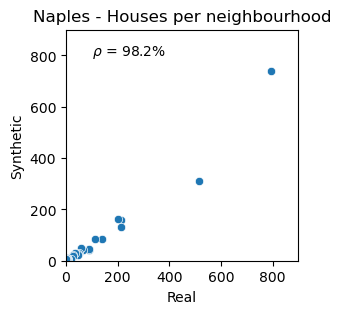

In [64]:
df_count = pd.concat([neigh_real.value_counts(), neigh_nfvae.value_counts()], axis = 1)
df_count.columns = ["real", "nfvae"]

fig, axes = sbp(figsize = (3,3))
sns.scatterplot(data = df_count, x = "real", y = "nfvae")
axes.set_xlim(0,900)
axes.set_ylim(0,900)

axes.text(x = 100, y = 800, s = r"$\rho$ = 98.2%")

axes.set_title("Naples - Houses per neighbourhood")
axes.set_xlabel("Real")
axes.set_ylabel("Synthetic")

In [65]:
df_count.corr()

,real,nfvae
real,1.000000,0.989231
nfvae,0.989231,1.000000


In [66]:
cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'Air conditioning',
       'Elevator', 'Self check-in', 'Pets allowed', 'Private living room',
       'Backyard', 'Pool', 'roomtype_Entire home/apt',
       'roomtype_Hotel room', 'roomtype_Private room', 'roomtype_Shared room',
       'review_scores_rating', 'reviews_per_month',
       'log_price', 'x', 'y']

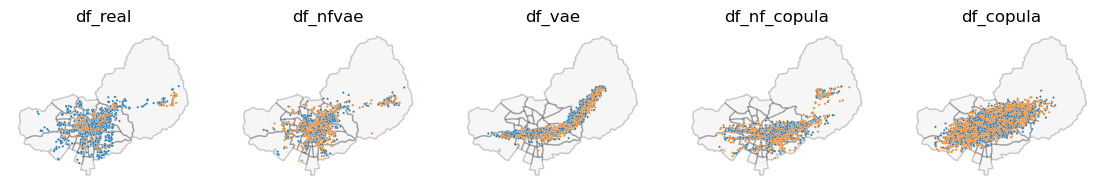

In [67]:
fig, axes = sbp(ncols = 5, nrows = 1, figsize = (14,3))

for k, key in enumerate(["df_real", "df_nfvae", "df_vae", "df_nf_copula", "df_copula"]):
    df_ = all_baselines[key]
    gdf_full["geometry"].plot(ax = axes[k], color = "lightgrey", alpha = 0.2, edgecolor = "black")
    pl = sns.scatterplot(data = df_.assign(Elevator = lambda x: x["Elevator"] == 1), x = "x", y = "y", 
                    hue = "Elevator",
                     #hue = "log_price",
                     #palette = "YlOrRd",
                    #hue_norm = (3., 6.),
                    s = 2.5,
                    ax = axes[k],
                    legend = False,
                    )
    

    #fig.colorbar(pl, ax = axes[k])
    for spine in axes[k].spines.values():
        spine.set_visible(False)

    axes[k].set_title(key)
    axes[k].set_xlabel("")
    axes[k].set_ylabel("")
    axes[k].set_xticks([])
    axes[k].set_yticks([])

In [20]:
glob(airbnb_path + f"pop_samples/*250924.csv")

['/data/housing/data/intermediate/jl_pop_synth/airbnb/pop_samples/washington dc_df_real95_250924.csv',
 '/data/housing/data/intermediate/jl_pop_synth/airbnb/pop_samples/washington dc_df_copula95_250924.csv',
 '/data/housing/data/intermediate/jl_pop_synth/airbnb/pop_samples/washington dc_df_real_250924.csv',
 '/data/housing/data/intermediate/jl_pop_synth/airbnb/pop_samples/washington dc_df_copula_250924.csv',
 '/data/housing/data/intermediate/jl_pop_synth/airbnb/pop_samples/washington dc_df_nf_copula95_250924.csv',
 '/data/housing/data/intermediate/jl_pop_synth/airbnb/pop_samples/synhtetic_pop_washington dc_250924.csv',
 '/data/housing/data/intermediate/jl_pop_synth/airbnb/pop_samples/washington dc_df_nf_copula_250924.csv']

In [6]:
def assign_discrete_variables(df, df_real):
    amenities_vars = ["Air conditioning", "Elevator", "Self check-in", "Pets allowed", "Private living room", "Backyard", "Pool"]

    for var in [u for u in amenities_vars]:
        df[var] = (df[var] > df[var].quantile(1 - df_real[var].astype(np.float32).mean())) + 0.

    df[["accommodates","bathrooms","bedrooms","beds"]] = df[["accommodates","bathrooms","bedrooms","beds"]].astype(int) + 0.

    return df


In [14]:
from jl_nflows_geo_coordinates import load_nf as load_dict
import torch
from sdv.single_table import GaussianCopulaSynthesizer, CTGANSynthesizer, TVAESynthesizer
from sdv.metadata import Metadata
from jl_synthetic_pop_copula_all_provinces import latent_to_real_coordinates
import jl_nflows_geo_coordinates_2 as nfg
from jl_nflows_geo_coordinates import load_nf as load_dict
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def latent_to_real_coordinates2(df_real, df_sample, path_nf):
    nf_dict = load_dict(path_nf)

    transf_xy = nfg.nf_latent_to_real(nf_dict, np.array(df_sample[["y_latent", "x_latent"]].astype(np.float32)))
    df_sample["x_trans"] = transf_xy[:,0]
    df_sample["y_trans"] = transf_xy[:,1]
    
    scaler = MinMaxScaler((-1,1))
    scaler.fit(np.array(df_real[["x", "y"]]))
    df_sample[["x", "y"]] = scaler.inverse_transform(np.array(df_sample[["x_trans", "y_trans"]]))
    df_sample.drop(columns = ["x_trans", "y_trans", "x_latent", "y_latent"], inplace = True)
    return df_sample


def train_nf_copula(df, # with categorical features, not one-hot
                    num_samples, 
                    path_samples = "",
                    path_nf = "",
                    numeric_variables = ["review_scores_rating", "reviews_per_month", "log_price"]
                    ):
    df_mean, df_std = df[numeric_variables].mean(), df[numeric_variables].std()
    df_ = df.copy()
    df_[numeric_variables] = (df_[numeric_variables] - df_mean) / df_std

    nf_dict = load_dict(path_nf)
    inv_coord = nf_dict["flow"].flow.forward(torch.tensor(np.array(df_[["x_norm", "y_norm"]]), dtype = torch.float32))
    df_[["y_latent", "x_latent"]] = torch.sigmoid(inv_coord[0][-1]).detach().numpy()
    

    df_.dropna(inplace = True)
    df_real = df_.copy()
    df_.drop(columns = ["x", "y", "x_norm", "y_norm"], inplace = True)

    metadata = Metadata.detect_from_dataframe(df_)
    synthesizer = GaussianCopulaSynthesizer(metadata)
    synthesizer.fit(df_)
    synthesizer.reset_sampling()
    df_copula = synthesizer.sample(num_rows = num_samples)
    df_copula = latent_to_real_coordinates2(df_real, df_copula, path_nf)
    df_copula[numeric_variables] = df_copula[numeric_variables] * df_std + df_mean
    # df_copula.to_csv(path_samples)
    return df_copula


city = "cape town"
date_nf = "250908"
df_real = get_df_city_for_nf(city).rename(columns = {"neighbourhood_cleansed": "neighbourhood"})
            
df_real_cat = df_real.copy()

drop_cols = ['roomtype_Entire home/apt', 'roomtype_Hotel room',
                'roomtype_Private room', 'roomtype_Shared room']#, 'neighbourhood']
df_real_cat["roomtype"] = pd.from_dummies(df_real_cat[['roomtype_Entire home/apt', 'roomtype_Hotel room',
                'roomtype_Private room', 'roomtype_Shared room']]).iloc[:,0].to_list()
df_real_cat.drop(columns = drop_cols, inplace = True)

df_nf_copula = train_nf_copula(df = df_real_cat, num_samples = 5 * len(df_real),
                                        path_nf = airbnb_path + f"nf_models/{city}_{date_nf}.pkl",
                                        numeric_variables = ["review_scores_rating", "reviews_per_month", "log_price"])

            

In [9]:
city = "brisbane"
df_real = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_real_250924.csv", index_col = 0)
df_nf_copula = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_nf_copula_250924.csv", index_col = 0)
df_nf_vae = pd.read_csv(airbnb_path + f"pop_samples/synthetic_pop_{city}_250924.csv", index_col = 0)

gdf_full = read_json(city)

In [1]:
city = "brisbane"
df_real = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_real_250905.csv", index_col = 0)
df_old = pd.read_csv(airbnb_path + f"pop_samples/synthetic_pop_{city}_250901.csv", index_col = 0).sample(len(df_real))
df_new = pd.read_csv(airbnb_path + f"pop_samples/synthetic_pop_{city}_250924.csv", index_col = 0).sample(len(df_real))
df_old_copula = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_nf_copula_250905.csv", index_col = 0)
df_new_copula = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_nf_copula_250924.csv", index_col = 0)

df_old = assign_discrete_variables(df_old, df_real)
df_new = assign_discrete_variables(df_new, df_real)

gdf_full = read_json(city)

NameError: name 'pd' is not defined

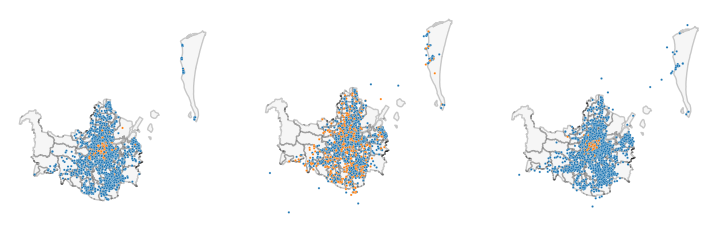

In [12]:
fig, axes = sbp(ncols = 3, nrows = 1, figsize = (9,3))

#for k, df_ in enumerate([df_real, df_old_copula, df_new_copula]):
#for k, df_ in enumerate([df_real, df_old, df_new]):
#for k, df_ in enumerate([df_real, df_old_copula, df_nf_copula.sample(len(df_real))]):
for k, df_ in enumerate([df_real, df_nf_copula.sample(len(df_real)), df_nf_vae.sample(len(df_real))]):
    
    gdf_full["geometry"].plot(ax = axes[k], color = "lightgrey", alpha = 0.2, edgecolor = "black")
    pl = sns.scatterplot(data = df_.assign(Elevator = lambda x: x["Elevator"] == 1), x = "x", y = "y", 
                    hue = "Elevator",
                     #hue = "log_price",
                     #palette = "YlOrRd",
                    #hue_norm = (3., 6.),
                    s = 2.5,
                    ax = axes[k],
                    legend = False,
                    )
    

    #fig.colorbar(pl, ax = axes[k])
    for spine in axes[k].spines.values():
        spine.set_visible(False)

    #axes[k].set_title(key)
    axes[k].set_xlabel("")
    axes[k].set_ylabel("")
    axes[k].set_xticks([])
    axes[k].set_yticks([])

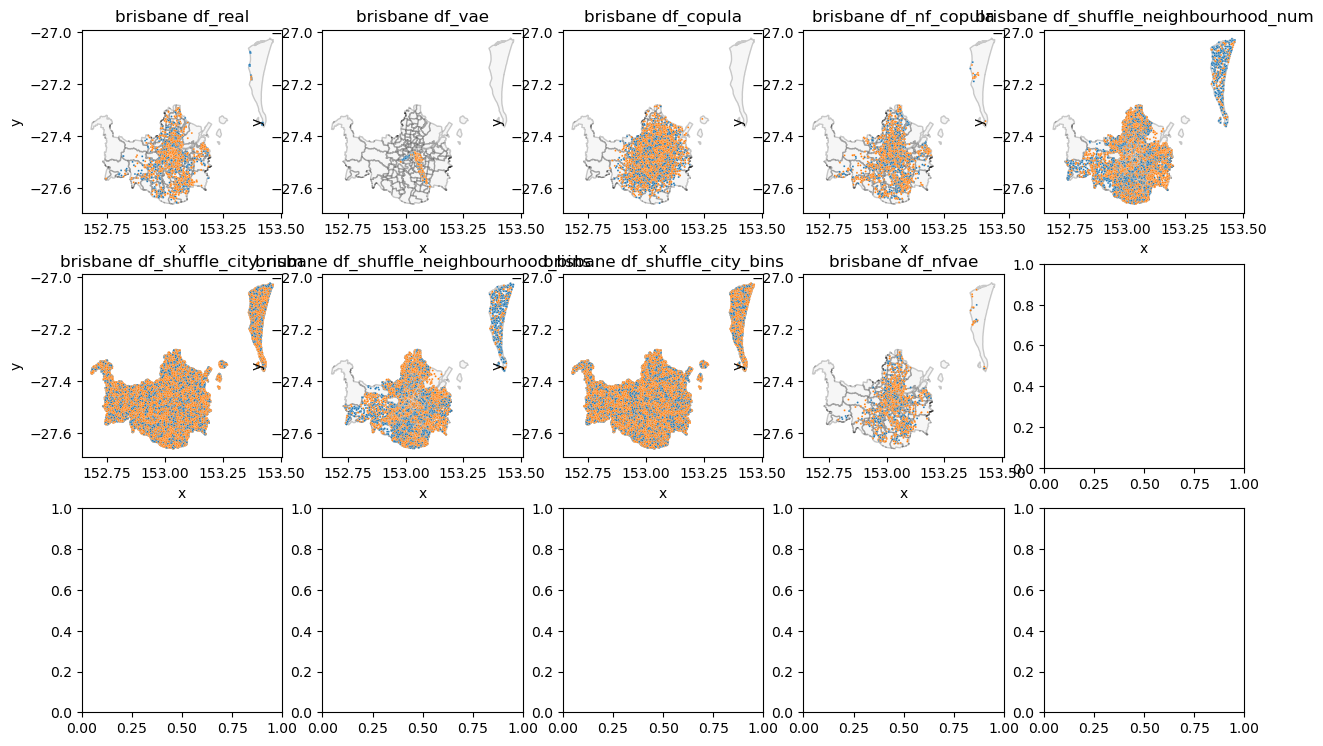

In [74]:
fig, axes = sbp(ncols = 5, nrows = 3, figsize = (15,9))

for k, key in enumerate([u for u in all_baselines.keys() if "95" not in u]):
    i,j = divmod(k,5)
    df_ = all_baselines[key]
    gdf_full["geometry"].plot(ax = axes[i,j], color = "lightgrey", alpha = 0.2, edgecolor = "black")
    sns.scatterplot(data = df_, x = "x", y = "y", 
                    hue = "Air conditioning",
                    # hue = "log_price",
                    # palette = "YlOrRd",
                    # hue_norm = (2.5, 8.),
                    s = 2,
                    ax = axes[i,j],
                    legend = False)

    axes[i,j].set_title(city + " " + key)

array([152.679699, -27.660374, 153.468495, -27.021952])

In [64]:
[u for u in p]

[<MULTIPOINT (153.124 -27.489, 153.125 -27.53, 153.132 -27.501, 153.146 -27.4...>]

### Save pickles

In [2]:
airbnb_path = "/data/housing/data/intermediate/jl_pop_synth/airbnb/"

In [3]:
city = "copenhagen"

df_full = read_gz(city, fn = "/listings.csv.gz")
df_full["amenities"] = [json.loads(u) for u in df_full["amenities"]]
amenities_vars = ["Air conditioning", "Elevator", "Self check-in", "Pets allowed", "Private living room", "Backyard", "Pool"]
for var in amenities_vars:
    df_full[var] = [var in u for u in df_full["amenities"]]

df = df_full[['id', 'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'price',
       'review_scores_rating', 'reviews_per_month'] + amenities_vars].rename(columns = {"latitude": "y", "longitude": "x"})

In [4]:
gdf_full = read_json(city)
gdf = gdf_full[["neighbourhood","geometry"]].dissolve().to_crs('EPSG:4326')

In [5]:
df_real = df.dropna().assign(price_num = lambda x: [float(u[1:].split(".")[0].replace(",", "")) for u in x["price"]]).assign(log_price = lambda x: np.log(x["price_num"]))

In [ ]:
# date = "250703"
date = "250811"

if os.path.exists(airbnb_path + f"pop_samples/synthetic_pop_in_polygon_{city}_{date}.csv"):
    df_nfvae = pd.read_csv(airbnb_path + f"pop_samples/synthetic_pop_in_polygon_{city}_{date}.csv", index_col = 0)
else:
    df_nfvae = pd.read_csv(airbnb_path + f"pop_samples/synthetic_pop_{city}_{date}.csv", index_col = 0)

    gdf_nfvae = gpd.GeoDataFrame(df_nfvae, geometry = gpd.points_from_xy(df_nfvae["x"], df_nfvae["y"])) 
    ## slow
    
    # obs_in_city = gdf_nfvae.within(gdf_full["geometry"].union_all())
    # df_nfvae = df_nfvae.loc[obs_in_city]
    # this is faster
    # gpd.tools.sjoin(df_valid, census, predicate="within", how='left')
    # gdf.within(gdf_full["geometry"])
    # df_sample_points = gpd.GeoDataFrame(df_nfvae, geometry = gpd.points_from_xy(gdf_full["x"], gdf_full["y"]))
    gdf_nfvae = gpd.GeoDataFrame(df_nfvae, geometry = gpd.points_from_xy(df_nfvae["x"], df_nfvae["y"]), crs = "EPSG:4326")
    gdf_nfvae = gpd.tools.sjoin(gdf_nfvae, gdf_full, predicate="within", how='left')
    
    df_nfvae = (pd.DataFrame(gdf_nfvae)
                .drop(columns = ["geometry"])
                .query("(review_scores_rating >= 0)&(review_scores_rating <= 5)&(reviews_per_month >= 0)")
                 .dropna(subset = "neighbourhood")[df_nfvae.columns]
                 .sample(n = len(df_real), random_state = 10075))
    # for var in [u for u in amenities_vars]:
    #     df_nfvae[var] = df_nfvae[var] > df_nfvae[var].quantile(1 - df_full[var].astype(np.float32).mean())

    # df_nfvae[["accommodates","bathrooms","bedrooms","beds"]] = df_nfvae[["accommodates","bathrooms","bedrooms","beds"]].astype(int)
    df_nfvae.to_csv(airbnb_path + f"pop_samples/synthetic_pop_in_polygon_{city}_{date}.csv")


In [ ]:
# cod_prov = cod_prov_abbrv_df.query("prov_abbrv == @prov")["COD_PROV"].iloc[0]

# df_real = pd.read_csv(jl_vae.path_pop_synth + f"real_populations/df_real_{prov}.csv", index_col = 0)
# df_real95 = df_real.sample(frac = 0.95, random_state = 1111)
# df_excluded = df_real[~df_real.index.isin(df_real95.index)]


#### df_nfvae = pd.read_csv(jl_vae.path_pop_synth + f"pop_samples/synthetic_pop_full_250709price_{prov}.csv", index_col = 0)
# df_vae = pd.read_csv(jl_vae.path_pop_synth + f"pop_samples_ablation/synthetic_pop_full_250710{prov}.csv", index_col = 0)

# df_nfvae95 = pd.read_csv(jl_vae.path_pop_synth + f"95sample/pop_samples/synthetic_pop_full_250703{prov}.csv", index_col = 0)

# df_copula_ablation = pd.read_csv(jl_vae.path_pop_synth + f"copula_samples/df_copula_ablation_{prov}.csv", index_col = 0)
# df_copula_nf = pd.read_csv(jl_vae.path_pop_synth + f"copula_samples/df_copula_nf_{prov}.csv", index_col = 0)
# df_copula_ablation95 = pd.read_csv(jl_vae.path_pop_synth + f"copula_samples/df_copula_ablation95_{prov}.csv", index_col = 0)
# df_copula_nf95 = pd.read_csv(jl_vae.path_pop_synth + f"copula_samples/df_copula_nf95_{prov}.csv", index_col = 0)

# df_ipf = pd.read_csv(jl_vae.path_pop_synth + f"ipf_samples/df_sample_{prov}_250718.csv", index_col = 0)
# df_ipf95 = pd.read_csv(jl_vae.path_pop_synth + f"ipf_samples/df_sample95_{prov}_250718.csv", index_col = 0)

# census_filter = census.assign(prov_cod = lambda x: [u[:3] for u in x["PRO_COM"]]).query("prov_cod == @cod_prov")
# polyg = census_filter[["prov_cod", "geometry"]].dissolve().to_crs('EPSG:4326')




In [6]:
import jl_nflows_geo_coordinates_2 as nfg
from jl_nflows_geo_coordinates import load_nf as load_dict
import torch
import jl_vae
from jl_synthetic_ipf_all_provinces import transform_bins, transform_bins_to_real
from jl_synthetic_pop_copula_all_provinces import latent_to_real_coordinates
from sdv.single_table import GaussianCopulaSynthesizer, CTGANSynthesizer, TVAESynthesizer
from sdv.metadata import Metadata


def train_nf_vae(df,  # contain ["x_norm, y_norm"]
                 num_layers_nf = 32,
                 hidden_features_nf = 32,
                 num_epochs_nf = 20000,
                 lr_nf = 1 / 100000,
                 opt_nf = "Adam" ,
                 flow_name = "NSF_CL",
                 batch_dim_nf = 100,
                 latent_dims_vae = 15,
                 epochs_vae = 100,
                 middle_hidden_dims_vae = [64, 32],
                 lr_vae = 0.001,
                 batch_size_vae = 100,
                 weight_reconstruction_vae = 10,
                 weight_kl_vae = 0.1,
                 weights_geo_vae = 30,
                 opt_vae = "Adam",
                 date = "250703",
                 path_nf = "",
                 path_vae = "",
                 path_settings = "",
                 path_samples = "",
                 n_samples = 100000,
                 train_nf = False):
    
        model_settings = {"num_layers_nf": num_layers_nf, "hidden_features_nf": hidden_features_nf, 
                        "num_epochs_nf": num_epochs_nf, "lr_nf": lr_nf, "opt_nf": opt_nf, "flow_name": flow_name,
                        "batch_dim": batch_dim_nf}

        
        if train_nf:
            nf_dict = nfg.train_model(df[["x_norm", "y_norm"]], 
                                    num_layers = num_layers_nf, 
                                    hidden_features = hidden_features_nf,
                                    num_epochs = num_epochs_nf, 
                                    opt_name = opt_nf, 
                                    batch_dim = batch_dim_nf, 
                                    flow_name = flow_name,
                                    hide_progress = True, 
                                    path = path_nf,
                                    model_settings = model_settings)
        else:
             nf_dict = load_dict(path_nf)
        
        inv_coord = nf_dict["flow"].flow.forward(torch.tensor(np.array(df[["x_norm", "y_norm"]]), dtype = torch.float32))
        df[["y_latent", "x_latent"]] = torch.sigmoid(inv_coord[0][-1]).detach().numpy()
                                                
        hidden_dims_vae = [df.drop(columns = ["x", "y", "x_norm", "y_norm"]).shape[1]] + middle_hidden_dims_vae 

        vae = jl_vae.VariationalAutoencoder(full_df = df.astype(np.float32),
                                            latent_dims = latent_dims_vae,
                                            hidden_dims = hidden_dims_vae,
                                                            )
                        
        vae.train(epochs = epochs_vae,
                lr = lr_vae,
                hide_tqdm = True,
                verbose = False, 
                opt_name = opt_vae,
                batch_size = batch_size_vae,
                weight_reconstruction = weight_reconstruction_vae,
                weight_kl = weight_kl_vae,
                weights_geo = weights_geo_vae,
                kl_annealing = False
            )

                        
        vae.save(path_vae)
        vae.save_settings(path_settings)
                        
        df_sample = vae.get_sample_from_vae(nf_dict = nf_dict, n_samples = n_samples)

                        
        df_sample.to_csv(path_samples)

def train_only_vae(df,  # contain ["x_norm, y_norm"]
                 latent_dims_vae = 15,
                 epochs_vae = 100,
                 middle_hidden_dims_vae = [64, 32],
                 lr_vae = 0.001,
                 batch_size_vae = 100,
                 weight_reconstruction_vae = 10,
                 weight_kl_vae = 0.1,
                 weights_geo_vae = 30,
                 opt_vae = "Adam",
                 date = "250703",
                 path_vae = "",
                 path_settings = "",
                 path_samples = "",
                 n_samples = 100000,
                 ):
    
        df[["y_latent", "x_latent"]] = df[["x_norm", "y_norm"]] / 2 + 0.5
                                                
        hidden_dims_vae = [df.drop(columns = ["x", "y", "x_norm", "y_norm"]).shape[1]] + middle_hidden_dims_vae 

        vae = jl_vae.VariationalAutoencoder(full_df = df.astype(np.float32),
                                            latent_dims = latent_dims_vae,
                                            hidden_dims = hidden_dims_vae,
                                                            )
                        
        vae.train(epochs = epochs_vae,
                lr = lr_vae,
                hide_tqdm = True,
                verbose = False, 
                opt_name = opt_vae,
                batch_size = batch_size_vae,
                weight_reconstruction = weight_reconstruction_vae,
                weight_kl = weight_kl_vae,
                weights_geo = weights_geo_vae,
                kl_annealing = False
            )

                        
        vae.save(path_vae)
        vae.save_settings(path_settings)
                        
        df_sample = vae.get_sample_from_vae(nf_dict = None, n_samples = n_samples)

                        
        df_sample.to_csv(path_samples)

def train_ipf(df, # must contain column var_area
              gdf_area,
              var_area = "CAP",
              numeric_variables = ["log_price", "log_mq"],
              num_bins = 5,
              seed = 2,
              ratio_syn_real = 10,
              path_pop_sample = "",
              ):
    df.dropna(inplace = True)
    ran_x = np.random.uniform(low = df["x"].min(), high = df["x"].max(), size = 1000000)
    ran_y = np.random.uniform(low = df["y"].min(), high = df["y"].max(), size = 1000000)
    ids = np.arange(1000000)

    df_locations = gpd.points_from_xy(ran_x, ran_y, z = None, crs = "EPSG:3035")
    df_locations = gpd.GeoDataFrame(pd.Series(ids, name = "id"), geometry= df_locations)
    df_locations = gpd.tools.sjoin(df_locations, gdf_area, predicate = "within", how = 'left')
    df_locations.drop(columns = 'index_right', inplace = True)
    df_locations["x"] = df_locations.geometry.x
    df_locations["y"] = df_locations.geometry.y

    df = df.dropna(subset = var_area)
    df_sample_list = []
            
    for area in df[var_area].unique():
        locations_area = df_locations.loc[df_locations[var_area] == area]
        df_area = df.drop(columns = ["x", "y"]).loc[df[var_area] == area].dropna()
        N_obs_area = len(df_area)
        if N_obs_area > 1:
            df_area = transform_bins(df_area, numeric_variables, q = num_bins)
            df_counts = df_area.value_counts().reset_index()
            sample_df_area = df_counts.sample(n = ratio_syn_real * N_obs_area, 
                                             weights = df_counts["count"],
                                             random_state = seed, 
                                             replace = True).drop(columns = ["count"])
            for var in numeric_variables:
                sample_df_area = transform_bins_to_real(sample_df_area, df, var, q = num_bins, seed = seed)
            
        else:
            sample_df_area = pd.concat([df_area] * ratio_syn_real)
                    
        if len(locations_area) > 0:
            sample_locations = locations_area.sample(n = ratio_syn_real * N_obs_area, replace = True, random_state = seed)
            sample_df_area["x"] = list(sample_locations["x"])
            sample_df_area["y"] = list(sample_locations["y"])
            sample_df_area[var_area] = area
                    
        df_sample_list.append(sample_df_area)
    sample_df = pd.concat(df_sample_list).reset_index().drop(columns = "index")

    # sample_df.to_csv(path_pop_sample)
    return sample_df

def train_only_copula(df, # with categorical features, not one-hot
                    num_samples, 
                    path_samples = "",
                    numeric_variables = ["review_scores_rating", "reviews_per_month", "log_price"]
                    ):
    df_mean, df_std = df[numeric_variables].mean(), df[numeric_variables].std()
    df[numeric_variables] = (df[numeric_variables] - df_mean) / df_std

    metadata = Metadata.detect_from_dataframe(df)
    synthesizer = GaussianCopulaSynthesizer(metadata)
    synthesizer.fit(df)
    synthesizer.reset_sampling()
    df_copula = synthesizer.sample(num_rows = num_samples)
    df_copula[numeric_variables] = df_copula[numeric_variables] * df_std + df_mean
    # df_copula.to_csv(path_samples)
    return df_copula

def train_nf_copula(df, # with categorical features, not one-hot
                    num_samples, 
                    path_samples = "",
                    path_nf = "",
                    numeric_variables = ["review_scores_rating", "reviews_per_month", "log_price"]
                    ):
    df_mean, df_std = df[numeric_variables].mean(), df[numeric_variables].std()
    df[numeric_variables] = (df[numeric_variables] - df_mean) / df_std

    nf_dict = load_dict(path_nf)
    inv_coord = nf_dict["flow"].flow.forward(torch.tensor(np.array(df[["x_norm", "y_norm"]]), dtype = torch.float32))
    df[["y_latent", "x_latent"]] = torch.sigmoid(inv_coord[0][-1]).detach().numpy()
    

    df.dropna(inplace = True)
    df_real = df.copy()
    df.drop(columns = ["x", "y", "x_norm", "y_norm"], inplace = True)

    metadata = Metadata.detect_from_dataframe(df)
    synthesizer = GaussianCopulaSynthesizer(metadata)
    synthesizer.fit(df)
    synthesizer.reset_sampling()
    df_copula = synthesizer.sample(num_rows = num_samples)
    df_copula = latent_to_real_coordinates(df_real, df_copula, path_nf)
    df_copula[numeric_variables] = df_copula[numeric_variables] * df_std + df_mean
    # df_copula.to_csv(path_samples)
    return df_copula

def from_cat_to_dummies_airbnb(df, features):
    df = pd.concat([
        pd.concat([pd.get_dummies(df["roomtype"], dtype = float), 
                   pd.DataFrame(columns = ['roomtype_Entire home/apt', 'roomtype_Hotel room', 'roomtype_Private room', 'roomtype_Shared room'])]),
        df.drop(columns = ["roomtype"])
        ], axis = 1)[features]
    
    return df


In [6]:
def select_n_in_border(df_sample, n, gdf, seed = 5):
    df_sample_points = gpd.GeoDataFrame(df_sample, geometry = gpd.points_from_xy(df_sample["x"], df_sample["y"]))
    df_sample = (gpd.tools.sjoin(df_sample_points, gdf, predicate="within", how='left')
                 .query("(review_scores_rating >= 0)&(review_scores_rating <= 5)&(reviews_per_month >= 0)")
                 .dropna(subset = "neighbourhood")[df_sample.columns]
                 .sample(n, random_state = seed))
    return df_sample

In [9]:
df_real = get_df_city_for_nf("copenhagen", keep_neighborhood = True).rename(columns = {"neighbourhood_cleansed": "neighbourhood"})
df_real95 = df_real.sample(frac = 0.95, random_state = 1234)

In [12]:
df_ipf = train_ipf(df = df_real, gdf_area = gdf_full, var_area = "neighbourhood",
          numeric_variables = ["review_scores_rating", "reviews_per_month", "log_price"])

df_ipf95 = train_ipf(df = df_real95, gdf_area = gdf_full, var_area = "neighbourhood",
          numeric_variables = ["review_scores_rating", "reviews_per_month", "log_price"])


In [13]:
df_real_cat = df_real.copy()
df_real_cat["roomtype"] = pd.from_dummies(df_real_cat[['roomtype_Entire home/apt', 'roomtype_Hotel room',
       'roomtype_Private room', 'roomtype_Shared room']]).iloc[:,0].to_list()
df_real_cat.drop(columns = ['roomtype_Entire home/apt', 'roomtype_Hotel room',
       'roomtype_Private room', 'roomtype_Shared room', 'neighbourhood'], inplace = True)
df_real_cat95 = df_real95.copy()
df_real_cat95["roomtype"] = pd.from_dummies(df_real_cat95[['roomtype_Entire home/apt', 'roomtype_Hotel room',
       'roomtype_Private room', 'roomtype_Shared room']]).iloc[:,0].to_list()
df_real_cat95.drop(columns = ['roomtype_Entire home/apt', 'roomtype_Hotel room',
       'roomtype_Private room', 'roomtype_Shared room', 'neighbourhood'], inplace = True)



In [14]:
df_copula = train_only_copula(df = df_real_cat,
                              num_samples = 5 * len(df_real),
                              numeric_variables = ["review_scores_rating", "reviews_per_month", "log_price"])
df_nf_copula = train_nf_copula(df = df_real_cat, num_samples = 5 * len(df_real),
                            path_nf = airbnb_path + f"nf_models/{city}_250703.pkl",
                            numeric_variables = ["review_scores_rating", "reviews_per_month", "log_price"])

df_copula95 = train_only_copula(df = df_real_cat95, 
                              num_samples = 5 * len(df_real),
                              numeric_variables = ["review_scores_rating", "reviews_per_month", "log_price"])
df_nf_copula95 = train_nf_copula(df = df_real_cat95, num_samples = 5 * len(df_real),
                            path_nf = airbnb_path + f"nf_models/{city}_250806_95.pkl",
                            numeric_variables = ["review_scores_rating", "reviews_per_month", "log_price"])

In [15]:
cols = [u for u in df_real.columns if ("norm" not in u)&("neighbourhood" not in u)]

In [17]:
date = "250811"

In [28]:
for city in ["copenhagen", "brisbane", "hawaii", "naples", "paris", "barcelona"]:
    print(city)
    gdf_full = read_json(city)

    df_nfvae = pd.read_csv(airbnb_path + f"pop_samples/synthetic_pop_{city}_{date}.csv", index_col = 0)
    df_nfvae95 = pd.read_csv(airbnb_path + f"pop_samples/synthetic_pop_{city}_{date}_95.csv", index_col = 0)
    df_vae = pd.read_csv(airbnb_path + f"pop_samples/synthetic_pop_{city}_{date}_ablation.csv", index_col = 0)
    df_vae95 = pd.read_csv(airbnb_path + f"pop_samples/synthetic_pop_{city}_{date}_ablation_95_ablation.csv", index_col = 0)
    df_real = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_real_{date}.csv", index_col = 0)
    df_real95 = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_real95_{date}.csv", index_col = 0)
    df_ipf = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_ipf_{date}.csv", index_col = 0)
    df_ipf95 = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_ipf95_{date}.csv", index_col = 0)
    df_copula = pd.read_csv(airbnb_path +f"pop_samples/{city}_df_copula_{date}.csv", index_col = 0)
    df_nf_copula = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_nf_copula_{date}.csv", index_col = 0)
    df_copula95 = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_copula95_{date}.csv", index_col = 0)
    df_nf_copula95 = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_nf_copula95_{date}.csv", index_col = 0)

    baselines_pop = {
        "df_real": df_real,
        "df_real95": df_real95,
        "df_vae": select_n_in_border(df_vae, seed = 5, n = len(df_real), gdf = gdf_full),
        "df_vae95": select_n_in_border(df_vae95, seed = 5, n = len(df_real), gdf = gdf_full),
        "df_copula": select_n_in_border(df_copula, seed = 5, n = len(df_real), gdf = gdf_full),
        "df_copula95": select_n_in_border(df_nf_copula, seed = 5, n = len(df_real), gdf = gdf_full),
        "df_nf_copula": select_n_in_border(df_copula95, seed = 5, n = len(df_real), gdf = gdf_full),
        "df_nf_copula95": select_n_in_border(df_nf_copula95, seed = 5, n = len(df_real), gdf = gdf_full),
        "df_ipf": select_n_in_border(df_ipf.drop(columns = ["neighbourhood"]), seed = 5, n = len(df_real), gdf = gdf_full),
        "df_ipf95": select_n_in_border(df_ipf95.drop(columns = ["neighbourhood"]), seed = 5, n = len(df_real), gdf = gdf_full),
        "df_nfvae": select_n_in_border(df_nfvae, seed = 5, n = len(df_real), gdf = gdf_full),
        "df_nfvae95": select_n_in_border(df_nfvae95, seed = 5, n = len(df_real), gdf = gdf_full),
    }

    with open(f'/data/housing/data/intermediate/jl_pop_synth/airbnb_baselines/all_baselines_{city}.pickle', 'wb') as f:
        pickle.dump(baselines_pop, f)

copenhagen
brisbane


ValueError: a must be greater than 0 unless no samples are taken

In [55]:
bins_values

array([-330.25266723,  -84.39395281,  -28.11944907,   28.4006179 ,
         86.93241799,  282.52306129])

In [54]:
s0 = pd.Series(100 * np.random.randn(1000))
s1 = pd.qcut(s0, q = 5, labels = False, duplicates = "drop").fillna(0).astype(int)

bins_values = pd.qcut(s0, q = 5, labels = False, duplicates = "drop", retbins = True)[1]
[np.random.uniform(low = bins_values[u], high = bins_values[u + 1]) for u in s1]

[-66.5614415577974,
 -11.403438585787239,
 65.447032408485,
 -324.61189668419274,
 36.302755588708585,
 -28.398458011442663,
 -168.5572003368035,
 112.94333742360789,
 -253.03056706663506,
 50.5179377540135,
 -18.314422709565527,
 -267.01224472071124,
 -18.988144087395526,
 -117.73201279103478,
 65.55034834184602,
 48.429670587648594,
 27.769042189457757,
 234.69468622637822,
 205.64684281760645,
 83.31902056972571,
 6.8888938542218625,
 -174.34138576913568,
 -83.25297406686789,
 168.42810163320138,
 76.05533066936894,
 82.70831306032578,
 275.0245392879432,
 116.96480636712434,
 33.17124023888754,
 22.079079551809855,
 70.96500159020744,
 216.53217565092956,
 -4.780820180263742,
 83.42326807647909,
 -55.15718868918539,
 -56.86382288953574,
 -141.2399584988469,
 -63.525160590777986,
 81.08423391897821,
 -280.2371799234451,
 71.67903308137085,
 35.363685832277284,
 154.21560762411866,
 212.72613850906598,
 -16.100684608632477,
 -200.72087457603254,
 -48.653521417166665,
 -78.33517930574

In [50]:
s0

0       71.641847
1      -96.640937
2       13.864140
3       10.802280
4       43.432451
          ...    
995     59.209381
996   -102.343764
997     96.731691
998   -172.475640
999    151.153277
Length: 1000, dtype: float64

In [36]:
df_nf_copula[["x", "y"]]

,x,y
0,12.568933,55.652410
1,12.608937,55.664510
2,12.539715,55.663246
3,12.573279,55.645264
4,12.532062,55.708100
...,...,...
54385,12.572675,55.658570
54386,12.463202,55.643555
54387,12.575931,55.656723
54388,12.583830,55.634740


In [72]:
set(baselines_pop["df_real"].columns) - set(baselines_pop["df_copula"].columns)

{'neighbourhood',
 'roomtype_Entire home/apt',
 'roomtype_Hotel room',
 'roomtype_Private room',
 'roomtype_Shared room'}

In [69]:
"neighbourhood", "x_norm", "y_norm"

('neighbourhood', 'x_norm', 'y_norm')

In [120]:
v = "Pool"
df_real[v].mean(), df_nfvae[v].mean()

(0.0017466446037874609, 0.47967828894747755)

In [127]:
v = "bathrooms"
df_real[v].value_counts(normalize = True), df_nfvae[v].value_counts(normalize = True)

(bathrooms
 1    0.919195
 2    0.067108
 0    0.010756
 3    0.002666
 5    0.000184
 4    0.000092
 Name: proportion, dtype: float64,
 bathrooms
  0    0.484507
  1    0.477131
  2    0.034867
  3    0.003347
  4    0.000118
 -1    0.000030
 Name: proportion, dtype: float64)

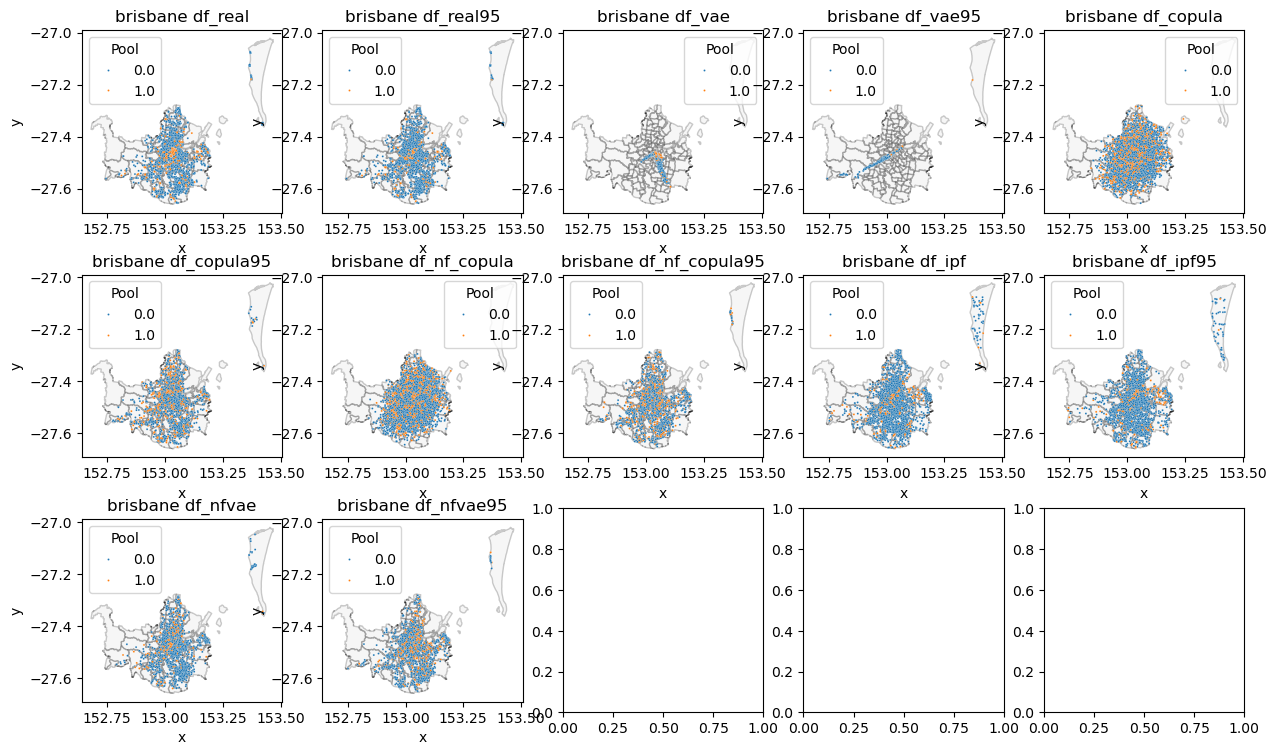

In [82]:
fig, axes = sbp(ncols = 5, nrows = 3, figsize = (15,9))

for k, key in enumerate(baselines_pop.keys()):
    i,j = divmod(k,5)
    df_ = baselines_pop[key]
    gdf_full["geometry"].plot(ax = axes[i,j], color = "lightgrey", alpha = 0.2, edgecolor = "black")
    sns.scatterplot(data = df_, x = "x", y = "y", 
                    hue = "Pool",
                    # hue = "log_price",
                    # vmin = 3.5, vmax = 8,
                    # cmap = "RdBu",
                    s = 2,
                    ax = axes[i,j])

    axes[i,j].set_title(city + " " + key)

In [54]:
integer_columns = ['accommodates', 'bathrooms', 'bedrooms', 'beds']
bool_columns =  ['Air conditioning', 'Elevator', 'Self check-in',
       'Pets allowed', 'Private living room', 'Backyard', 'Pool']



In [67]:
(df_nfvae[bool_columns] > 0).mean()

Air conditioning       0.956114
Elevator               0.920502
Self check-in          0.839740
Pets allowed           0.994929
Private living room    0.585186
Backyard               0.991740
Pool                   0.683144
dtype: float64

In [69]:
df_real[bool_columns].mean()

Air conditioning       0.016639
Elevator               0.135962
Self check-in          0.356315
Pets allowed           0.117853
Private living room    0.006343
Backyard               0.140375
Pool                   0.001747
dtype: float64

In [103]:
continuous_variables = ["review_scores_rating", "reviews_per_month", "log_price"]
integer_variables = ['accommodates', 'bathrooms', 'bedrooms', 'beds']
bool_variables =  ['Air conditioning', 'Elevator', 'Self check-in',
       'Pets allowed', 'Private living room', 'Backyard', 'Pool']
num_variables = continuous_variables + integer_variables + bool_variables


In [96]:
df = get_df_city_for_nf(city)
df_mean, df_std = df[num_variables].mean(), df[num_variables].std()
            

In [99]:
for var in num_variables:
    df[var] = (df[var] - df_mean[var]) / df_std[var]

ValueError: cannot reindex on an axis with duplicate labels

In [102]:
df.columns

Index(['y', 'x', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'review_scores_rating', 'reviews_per_month', 'Air conditioning',
       'Elevator', 'Self check-in', 'Pets allowed', 'Private living room',
       'Backyard', 'Pool', 'log_price', 'roomtype_Entire home/apt',
       'roomtype_Hotel room', 'roomtype_Private room', 'roomtype_Shared room',
       'x_norm', 'y_norm'],
      dtype='object')

In [6]:
city = "barcelona"
date = "250811"

In [11]:
df_real = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_real_{date}.csv", index_col = 0)
df_real95 = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_real95_{date}.csv", index_col = 0)
df_ipf = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_ipf_{date}.csv", index_col = 0)
df_ipf95 = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_ipf95_{date}.csv", index_col = 0)
df_copula = pd.read_csv(airbnb_path +f"pop_samples/{city}_df_copula_{date}.csv", index_col = 0)
df_nf_copula = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_nf_copula_{date}.csv", index_col = 0)
df_copula95 = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_copula95_{date}.csv", index_col = 0)
df_nf_copula95 = pd.read_csv(airbnb_path + f"pop_samples/{city}_df_nf_copula95_{date}.csv", index_col = 0)
df_nfvae = pd.read_csv(airbnb_path + f"pop_samples/synthetic_pop_{city}_{date}.csv", index_col = 0)
df_nfvae = pd.read_csv(airbnb_path + f"pop_samples/synthetic_pop_{city}_{date}.csv", index_col = 0)


FileNotFoundError: [Errno 2] No such file or directory: '/data/housing/data/intermediate/jl_pop_synth/airbnb/pop_samples/synthetic_pop_barcelona_250811.csv'

In [10]:
all_baselines = {
    "df_real": df_real,
    "df_real95": df_real95,
    "df_ipf": df_ipf.sample(n = len(df_real), random_state = 15),
    "df_ipf95": df_ipf95.sample(n = len(df_real95), random_state = 15),
    "df_copula": df_copula.sample(n = len(df_real), random_state = 15),
    "df_nf_copula": df_nf_copula.sample(n = len(df_real), random_state = 15),
    "df_copula95": df_copula95.sample(n = len(df_real95), random_state = 15),
    "df_nf_copula95": df_nf_copula95.sample(n = len(df_real95), random_state = 15),
}

In [9]:
{u: len(all_baselines[u]) for u in all_baselines}

{'df_real': 10878,
 'df_real95': 10334,
 'df_ipf': 108780,
 'df_ipf95': 103340,
 'df_copula': 54390,
 'df_nf_copula': 54390,
 'df_copula95': 54390,
 'df_nf_copula95': 54390}

In [ ]:

features_synpop = ['flag_garage', 'flag_pertinenza', 'flag_air_conditioning',
            'flag_multi_floor', 'log_mq', 'ANNO_COSTRUZIONE_1500_1965',
            'ANNO_COSTRUZIONE_1965_1985', 'ANNO_COSTRUZIONE_1985_2005',
            'ANNO_COSTRUZIONE_2005_2025', 'ANNO_COSTRUZIONE_Missing',
            'High_energy_class', 'Low_energy_class', 'Medium_energy_class',
            'Missing_energy_class', 'COD_CAT_A02', 'COD_CAT_A03',
            'COD_CAT_A_01_07_08', 'COD_CAT_A_04_05', 'floor_0.0', 'floor_1.0',
            'floor_2.0', 'floor_3.0', 'floor_Missing', 'floor_plus_4',
            'flag_air_conditioning_Missing', 'flag_multi_floor_Missing', 'y', 'x','log_price']


def transform_bins(df, vars, q = 5):
    df1 = df.copy()
    for var in vars:
        df1[var + "_bin"] =  pd.qcut(df1[var], q = q, labels = False, duplicates = "drop").fillna(0).astype(int)
        df1.drop(columns = [var], inplace = True)
    return df1

def transform_bins_to_real(sample_df, df_real, var, q = 5, seed = 2):
    bins_values = pd.qcut(df_real[var], q = q, labels = False, duplicates = "drop", retbins = True)[1]
    np.random.seed(seed)
    sample_df[var] = [np.random.uniform(low = bins_values[u], high = bins_values[u + 1]) for u in sample_df[var + "_bin"]]
    sample_df.drop(columns = [var + "_bin"], inplace = True)
    return sample_df


In [2]:
import sys
sys.path += ["../src"]
import geopandas as gpd
import pandas as pd
import numpy as np
import json

from jl_synthetic_pop_all_vae_provinces_airbnb import read_gz, read_json, get_df_city_for_nf
import jl_nflows_geo_coordinates_2 as nfg
from jl_nflows_geo_coordinates import load_nf as load_dict
import torch
import jl_vae
from jl_synthetic_ipf_all_provinces import transform_bins, transform_bins_to_real
from jl_synthetic_pop_copula_all_provinces import latent_to_real_coordinates
from sdv.single_table import GaussianCopulaSynthesizer, CTGANSynthesizer, TVAESynthesizer
from sdv.metadata import Metadata


In [3]:
city = "brisbane"
        
if True:
            df_full = read_gz(city, fn = "/listings.csv.gz")
            df_full["amenities"] = [json.loads(u) for u in df_full["amenities"]]
            amenities_vars = ["Air conditioning", "Elevator", "Self check-in", "Pets allowed", "Private living room", "Backyard", "Pool"]
            for var in amenities_vars:
                df_full[var] = [var in u for u in df_full["amenities"]]

            df = df_full[['id', 'neighbourhood_cleansed', 'latitude',
                'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
                'bedrooms', 'beds', 'price',
                'review_scores_rating', 'reviews_per_month'] + amenities_vars].rename(columns = {"latitude": "y", "longitude": "x"})


            gdf_full = read_json(city)
            gdf = gdf_full[["neighbourhood","geometry"]].dissolve().to_crs('EPSG:4326')


            df_real = get_df_city_for_nf(city, keep_neighborhood = True).rename(columns = {"neighbourhood_cleansed": "neighbourhood"})
            df_real95 = df_real.sample(frac = 0.95, random_state = 1234)
            print("ipf")


ipf


In [ ]:
            df_ipf = train_ipf(df = df_real, gdf_area = gdf_full, var_area = "neighbourhood",
                    numeric_variables = ["review_scores_rating", "reviews_per_month", "log_price"])

    

In [4]:
df = df_real.copy()
gdf_area = gdf_full
var_area = "neighbourhood"
numeric_variables = ["review_scores_rating", "reviews_per_month", "log_price"]
num_bins = 5
ratio_syn_real = 5
seed = 5

df.dropna(inplace = True)
if True:
    ran_x = np.random.uniform(low = df["x"].min(), high = df["x"].max(), size = 1000000)
    ran_y = np.random.uniform(low = df["y"].min(), high = df["y"].max(), size = 1000000)
    ids = np.arange(1000000)

    df_locations = gpd.points_from_xy(ran_x, ran_y, z = None, crs = "EPSG:3035")
    df_locations = gpd.GeoDataFrame(pd.Series(ids, name = "id"), geometry= df_locations)
    df_locations = gpd.tools.sjoin(df_locations, gdf_area, predicate = "within", how = 'left')
    df_locations.drop(columns = 'index_right', inplace = True)
    df_locations["x"] = df_locations.geometry.x
    df_locations["y"] = df_locations.geometry.y

    df = df.dropna(subset = var_area)
    df_sample_list = []
            
    for area in df[var_area].unique():
        locations_area = df_locations.loc[df_locations[var_area] == area]
        df_area = df.drop(columns = ["x", "y"]).loc[df[var_area] == area].dropna()
        N_obs_area = len(df_area)
        if N_obs_area > 1:
            df_area = transform_bins(df_area, numeric_variables, q = num_bins)
            df_counts = df_area.value_counts().reset_index()
            sample_df_area = df_counts.sample(n = ratio_syn_real * N_obs_area, 
                                             weights = df_counts["count"],
                                             random_state = seed, 
                                             replace = True).drop(columns = ["count"])
            for var in numeric_variables:
                sample_df_area = transform_bins_to_real(sample_df_area, df, var, q = num_bins, seed = seed)
            
        else:
            sample_df_area = pd.concat([df_area] * ratio_syn_real)
                    
        if len(locations_area) > 0:
            sample_locations = locations_area.sample(n = ratio_syn_real * N_obs_area, replace = True, random_state = seed)
            sample_df_area["x"] = list(sample_locations["x"])
            sample_df_area["y"] = list(sample_locations["y"])
            sample_df_area[var_area] = area
                    
        df_sample_list.append(sample_df_area)
    sample_df = pd.concat(df_sample_list).reset_index().drop(columns = "index")

    

IndexError: index 5 is out of bounds for axis 0 with size 5

In [8]:
sample_df_area["review_scores_rating_bin"].unique()

array([4, 3, 1, 0, 2])

In [12]:
q = 5
sample_df = sample_df_area.copy()
if True:
    bins_values = pd.qcut(df_real[var], q = q, labels = False, duplicates = "drop", retbins = True)[1]
    np.random.seed(seed)
    sample_df[var] = [np.random.uniform(low = bins_values[u], high = bins_values[u + 1]) for u in sample_df[var + "_bin"]]
    sample_df.drop(columns = [var + "_bin"], inplace = True)
    


IndexError: index 5 is out of bounds for axis 0 with size 5

In [ ]:
q = 5
pd.qcut(df_real[var], q = q, labels = False, duplicates = "drop", retbins = True)

SyntaxError: keyword argument repeated: labels (1149459970.py, line 2)

In [13]:
bins_values

array([1.  , 4.57, 4.76, 4.88, 5.  ])